### Zero-Shot Performance of `Qwen/Qwen2-VL-72B-Instruct` on `lucknow_airshed`

- load images and labels
- pre-process the images to match the model's input size
- developing prompts for zero-shot learning
- run infererence
- convert vlms output to labels format
- IoU between the predicted bounding boxes and the ground truth bounding boxes. The notes specify using an IoU threshold of 0.33.
- precision, recall

In [1]:
import os

import rasterio
# import shapely.geometry
import geojson

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torchvision.transforms as transforms
if torch.cuda.is_available():
    device = torch.device("cuda:3")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU")

In [9]:
def load_image_and_label(image_path, label_path, metadata):
    """
    Loads a GeoTIFF image, its corresponding YOLO-OBB label, and relevant metadata.

    Args:
        image_path: Path to the GeoTIFF image file.
        label_path: Path to the corresponding YOLO-OBB label file.
        metadata: The parsed GeoJSON metadata (as a Python dictionary).

    Returns:
        image: The loaded image (e.g., as a NumPy array or PIL Image).
        label: The parsed YOLO-OBB label data (format to be determined).
        image_metadata:  The metadata associated with this specific image.
    """

    # 1. Extract x and y from the filename:
    x, y = [int(i) for i in image_path.strip(".tif").split("/")[-1].split("_")]

    # 2. Find the corresponding metadata entry:
    image_metadata = find_metadata_entry(metadata, x, y)

    # 3. Load the GeoTIFF image using rasterio:
    with rasterio.open(image_path) as src:
        image = src.read()  # Read all bands into a NumPy array
        image_tensor = torch.from_numpy(image).float().to(device)/255

    # 4. Load and parse the YOLO-OBB label:
    label_data = parse_yolo_obb_label(label_path)
    label_tensor = yolo_obb_to_pytorch_tensor(label_data, device)    

    # 5. Preprocess the image (if needed):
    #image_tensor = preprocess_image(image) # Implement this function

    return image_tensor, label_tensor, image_metadata

def find_metadata_entry(metadata, x, y):
    """
    Finds the metadata entry corresponding to the given x and y values.
    """
    for feature in metadata['features']:
        if feature['properties']['x'] == x and feature['properties']['y'] == y:
            return feature
    return None

def parse_yolo_obb_label(label_path):
    """
    Parses the YOLO-OBB label file.

    Args:
        label_path: Path to the label file.

    Returns:
        A list of dictionaries, where each dictionary represents an object
        and contains the class index and bounding box coordinates.
    """
    objects = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            class_index = int(parts[0])
            coordinates = [float(x) for x in parts[1:]]
            
            # Store the coordinates as a list of (x, y) pairs
            points = [(coordinates[i], coordinates[i+1]) for i in range(0, len(coordinates), 2)]

            objects.append({
                "class_index": class_index,
                "points": points,  # List of (x, y) tuples
            })

    return objects

def yolo_obb_to_pytorch_tensor(label_data, device):
    """
    Converts parsed YOLO-OBB label data to a PyTorch tensor.

    Args:
        label_data: The list of dictionaries from parse_yolo_obb_label.
        device: The torch.device  to use.

    Returns:
        A PyTorch tensor representing the label data, on the specified device.
        The structure of this tensor will depend on how you want to use it
        in your VLM (e.g., you might concatenate class and coordinates).
    """
    tensor_list = []
    for obj in label_data:
        # Convert points to a tensor
        points_tensor = torch.tensor(obj["points"], dtype=torch.float, device=device)

        # Create a tensor for the class index
        class_tensor = torch.tensor([obj["class_index"]], dtype=torch.long, device=device)

        # Combine class index and points into a single tensor for each object
        object_tensor = torch.cat((class_tensor, points_tensor.view(-1)))

        tensor_list.append(object_tensor)

    # Stack all object tensors into a single tensor
    if tensor_list:
        label_tensor = torch.stack(tensor_list)
    else:
        label_tensor = torch.empty((0, 9), dtype=torch.float, device=device) 
        
    return label_tensor

def preprocess_image(image_tensor):
    """
    Preprocesses the image tensor using torchvision transforms.

    Args:
        image_tensor: The image as a PyTorch tensor.

    Returns:
        The preprocessed image tensor.
    """
    # Example transformations (adapt these to your VLM's requirements):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize (adjust size as needed)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
        # Add other transformations as needed
    ])
    
    # Ensure the tensor has 3 channels (e.g., by repeating a single channel 3 times)
    if image_tensor.shape[0] != 3:
        image_tensor = image_tensor.repeat(3, 1, 1)[:3, :, :]

    # Permute the dimensions to (C, H, W) if it's not already
    if image_tensor.shape[0] > 3:
      image_tensor = image_tensor.permute(2, 0, 1)

    image_tensor = preprocess(image_tensor)
    return image_tensor

def visualize_data(image_tensor, label_tensor):
    """
    Visualizes the image and bounding boxes, with different colors for each class.

    Args:
        image_tensor: The image as a PyTorch tensor (C, H, W).
        label_tensor: The label tensor containing bounding box info.
        class_colors: A dictionary mapping class indices to colors.
    """
    class_colors = {
        0: (1, 0, 0),  # Red for class 0
        1: (0, 1, 0),  # Green for class 1
        2: (0, 0, 1),  # Blue for class 2
    }

    # Move tensors to CPU and convert to numpy for plotting
    image_np = image_tensor.cpu().numpy()
    label_np = label_tensor.cpu().numpy()

    # Convert image to (H, W, C) format for plotting
    image_np = np.transpose(image_np, (1, 2, 0))

    # Denormalize the image (if it was normalized during preprocessing)
    #image_np = denormalize_image(image_np)  # Implement this function if needed

    # Create a figure and axes
    fig, ax = plt.subplots(1, figsize=(20, 20))

    # Display the image
    ax.imshow(image_np)
    ax.axis("off")

    # Iterate over bounding boxes
    for i in range(label_np.shape[0]):
        label = label_np[i]
        class_index = int(label[0])  # Assuming class index is the first element
        points = label[1:].reshape(-1, 2)  # Reshape to pairs of (x, y)

        # Convert normalized coordinates back to pixel coordinates
        height, width, _ = image_np.shape
        points[:, 0] *= width  # Scale x coordinates
        points[:, 1] *= height  # Scale y coordinates

        # Get the color for this class
        color = class_colors.get(class_index)  # Default to random color if not found

        # Create a polygon patch and add it to the plot
        polygon = patches.Polygon(points, closed=True, linewidth=4, edgecolor=color, facecolor='none')
        ax.add_patch(polygon)

    # Show the plot
    plt.show()

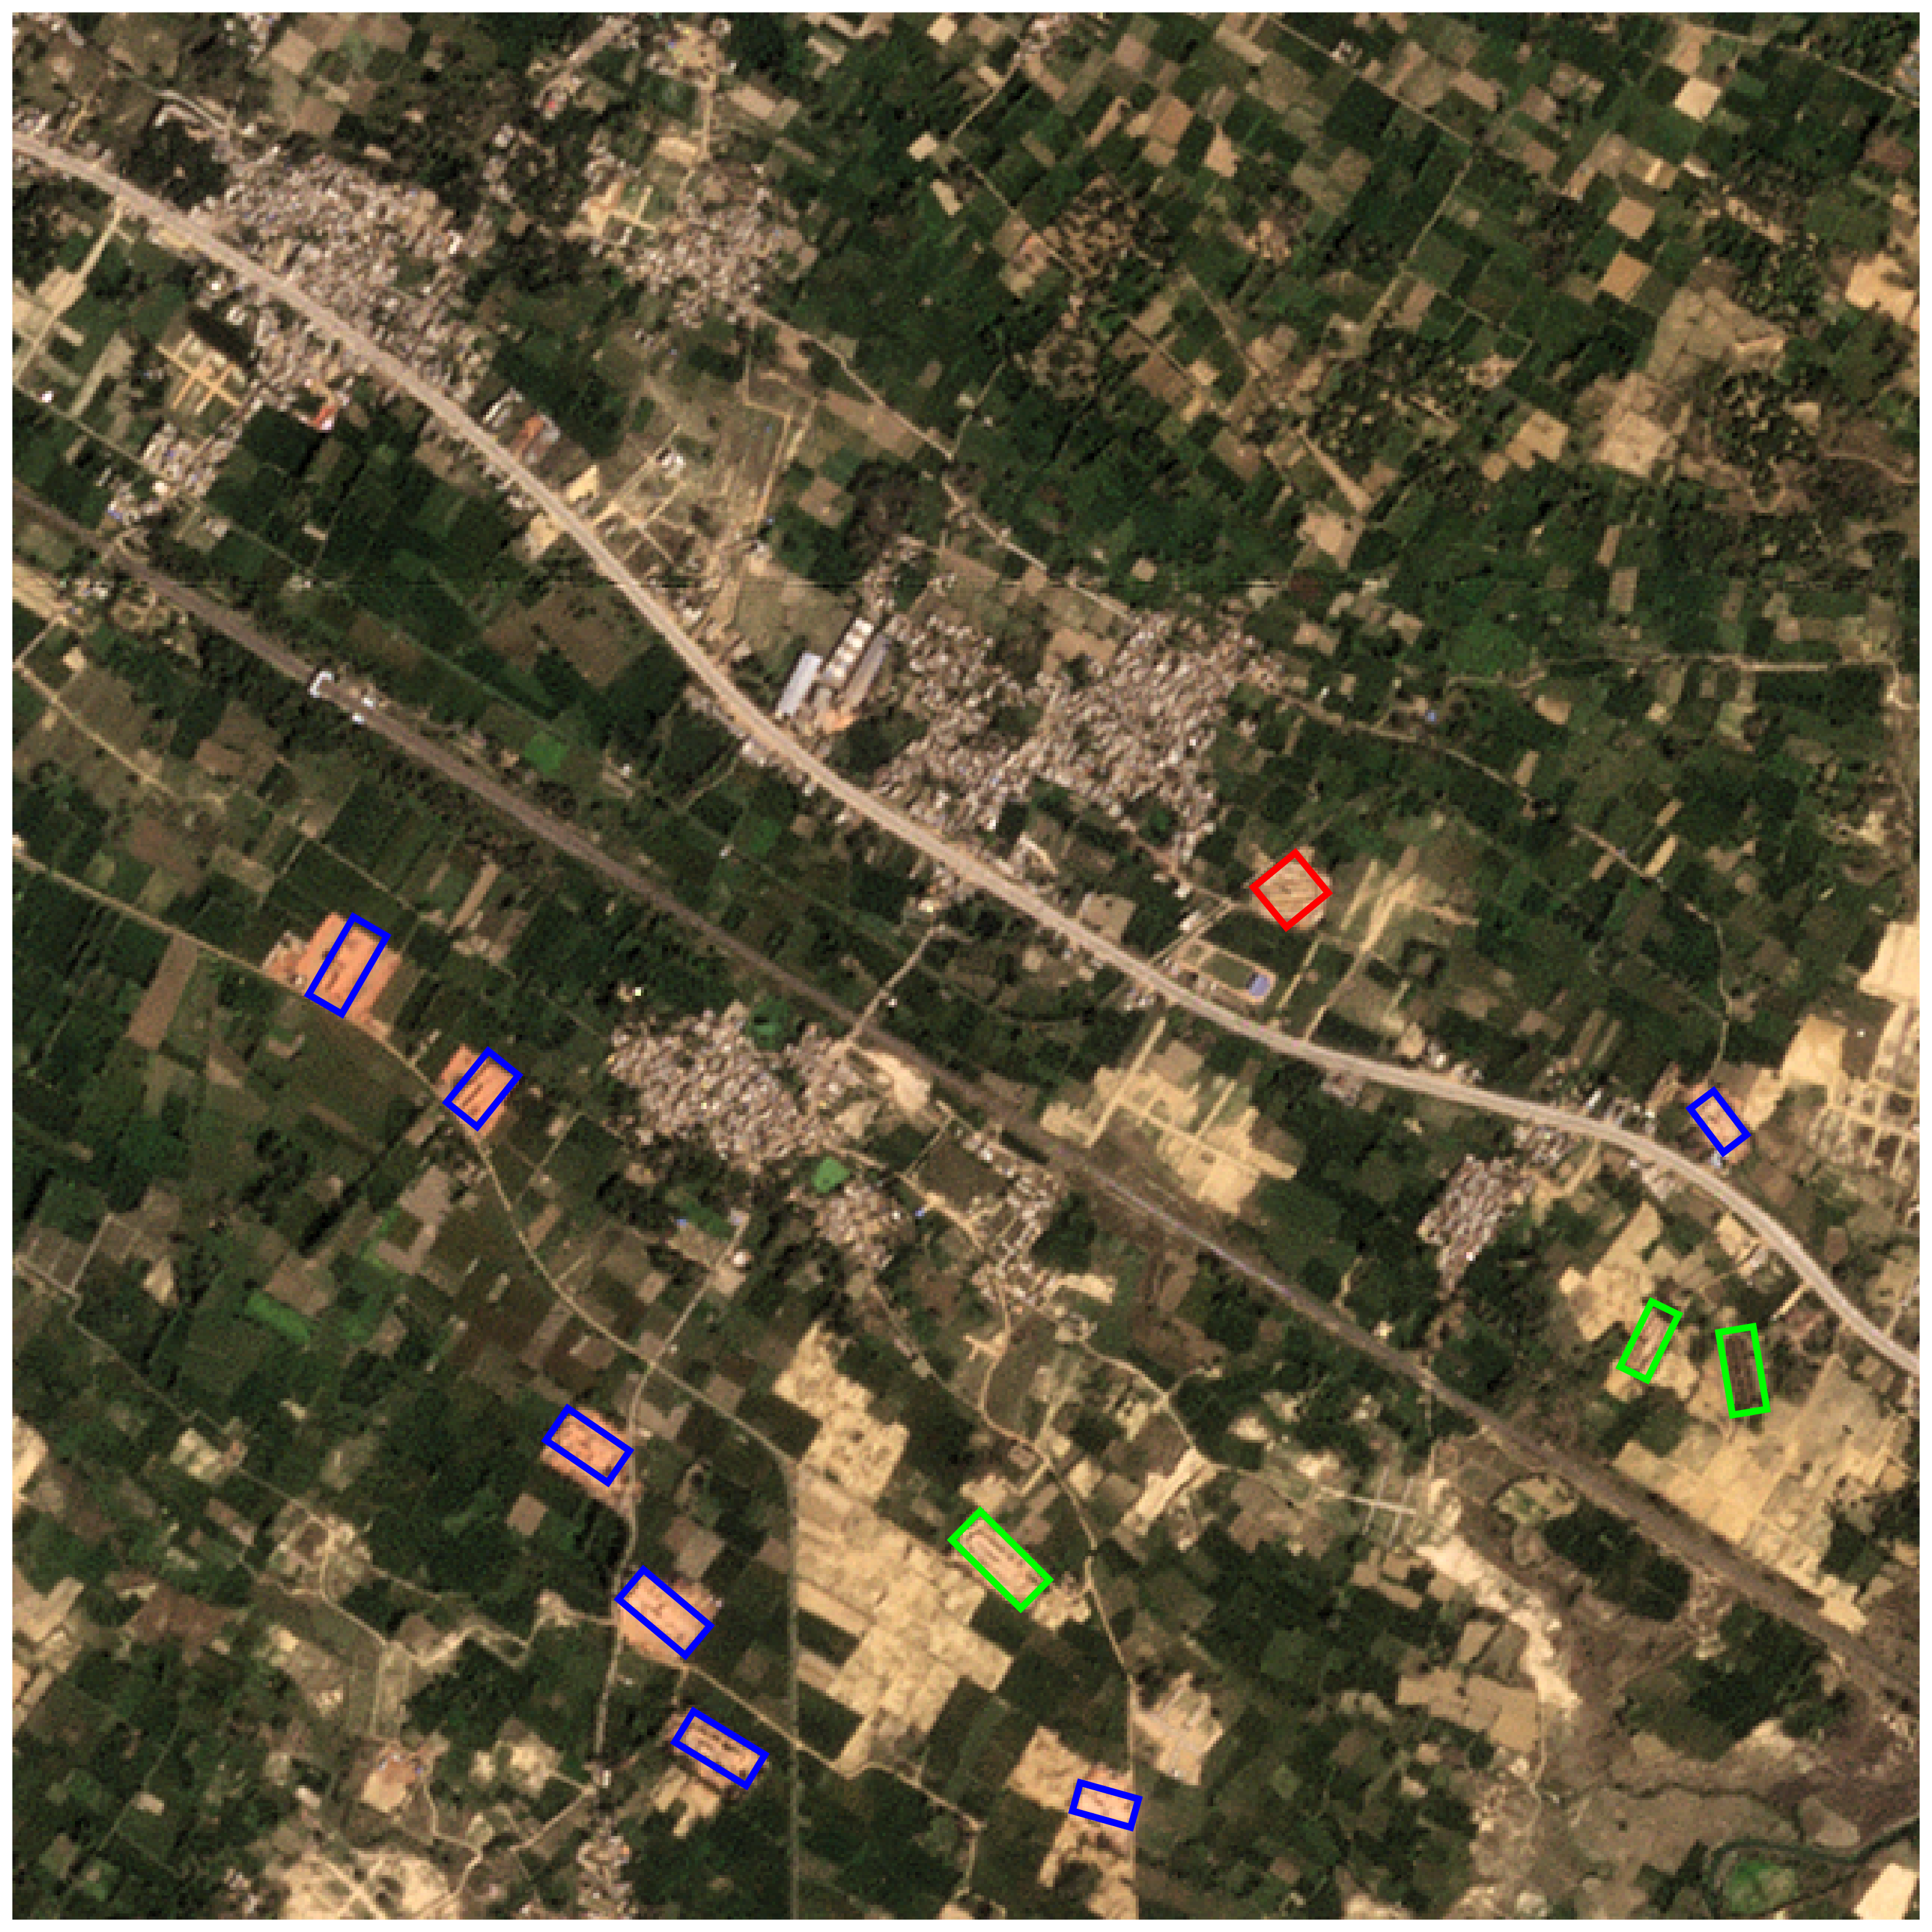

In [10]:
with open("data/lucknow_airshed/metadata.geojson") as f:
        metadata = geojson.load(f)
image_tensor,label_tensor, image_metadata = load_image_and_label("data/lucknow_airshed/images/9035164_3091111.tif",
                                                                  "data/lucknow_airshed/labels/9035164_3091111.txt",
                                                                  metadata)
visualize_data(image_tensor, label_tensor)

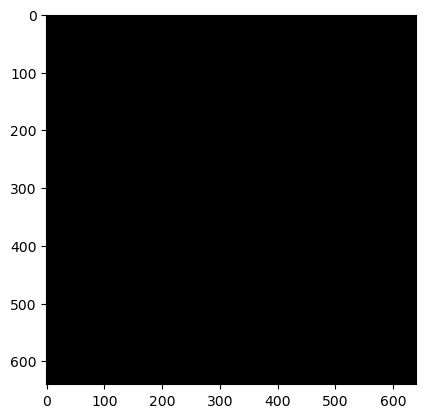

In [54]:
plt.imshow((image_tensor/255).permute(1, 2, 0).cpu().numpy())

In [55]:
parse_yolo_obb_label("data/lucknow_airshed/labels/8982881_3146145.txt")

[{'class_index': 2,
  'points': [(0.576949, 0.923212),
   (0.590202, 0.88728),
   (0.572253, 0.88065),
   (0.558963, 0.916583)]},
 {'class_index': 1,
  'points': [(0.755134, 0.916951),
   (0.777526, 0.868577),
   (0.762125, 0.861456),
   (0.73977, 0.90983)]},
 {'class_index': 2,
  'points': [(0.603564, 0.861006),
   (0.61882, 0.819425),
   (0.602472, 0.813409),
   (0.587217, 0.855031)]}]

In [56]:
label_files = os.listdir("data/lucknow_airshed/labels")
# go through all label .txt files and find which classes are present
class_set = set()
for label_file in label_files:
    with open("data/lucknow_airshed/labels/"+label_file) as f:
        for line in f:
            class_set.add(int(line.split()[0]))
class_set

{0, 1, 2}

In [6]:
label_files = os.listdir("data/lucknow_airshed/labels")
# go through all label .txt files and find which has all three class {0, 1, 2} and maximum lines
max_lines = 0
max_lines_file = ""
for label_file in label_files:
    with open("data/lucknow_airshed/labels/"+label_file) as f:
        lines = len(f.readlines())
        if lines >= 3:
            with open("data/lucknow_airshed/labels/"+label_file) as f:
                class_set = set()
                for line in f:
                    class_set.add(int(line.split()[0]))
                if class_set == {0, 1, 2}:
                    if lines > max_lines:
                        max_lines = lines
                        max_lines_file = label_file
max_lines_file

'9035164_3091111.txt'

In [7]:
with open("data/lucknow_airshed/labels/"+max_lines_file) as f:
    lines = f.readlines()
    for line in lines:
        print(line)

2 0.383927 0.928978 0.393793 0.912754 0.356365 0.889966 0.346498 0.906150

2 0.352032 0.860696 0.365067 0.845164 0.330078 0.815690 0.317007 0.831181

1 0.542851 0.820990 0.506661 0.785034 0.491697 0.800117 0.527887 0.836073

2 0.554976 0.942227 0.585559 0.950828 0.589710 0.935990 0.559126 0.927429

1 0.919174 0.731589 0.911928 0.688294 0.893833 0.691351 0.901115 0.734605

1 0.856295 0.716179 0.872825 0.682056 0.858735 0.675207 0.842169 0.709330

2 0.896345 0.597015 0.908579 0.587679 0.891175 0.564726 0.878905 0.574021

0 0.667188 0.478908 0.689142 0.460888 0.671884 0.439851 0.649930 0.457871

2 0.311400 0.770072 0.322832 0.753358 0.290392 0.731140 0.278923 0.747855

2 0.264615 0.556532 0.248704 0.543730 0.226931 0.570719 0.242879 0.583561

2 0.171954 0.524365 0.195547 0.483555 0.178071 0.473445 0.154514 0.514255

